# Deterministic optimisation

Here we optimise over several different objective functions evaluated using the deterministic fluid flow model. 

In [1]:
# imports
import deterministic_optimisation as do
import fluid_flow_model as fl
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# constraint funcs
def budget_constraint(problem):
    costs=0
    for t in problem.T:
        costs += problem.h[t] * costs_accomm['housing']
        costs += problem.s[t] * costs_accomm['shelter']
    return costs <= budget

def min_house_build(problem,n):
    return problem.h[n]>=baseline_build

def min_shelter_build(problem,n):
    return problem.s[n]>=baseline_build

In [3]:
# Set as is data
data_as_is = {'initial_capacity' : {'housing':4000, 'shelter':1500},
              'initial_demand' : 12000,
              'service_mean' : {'housing': 4.0, 'shelter': 0.0},
              'arrival_rates' : [4000.0, 4000.0, 4000.0, 4000.0, 4000.0]}

# Model setup
horizon = 5
timestep = 1/365
budget = 200000000
baseline_build = 500
costs_accomm = {'housing' : 30000, 'shelter' : 10000}
model = do.FluidModel

####  Phi 0
    # min TimeAvg(E[unsh(t)])
    # s.t. total budget constraint
    #      annual minimum build constraint

In [4]:
def y0(problem):
    " objective function for problem Phi0 "
    solution = {'housing' : problem.h, 'shelter' : problem.s}
    fluid_model = model(data_as_is, solution)
    fluid_model.analyse(horizon, timestep)
    avg_unsh = sum(fluid_model.model.unsh_t)/len(fluid_model.model.unsh_t)
    return(avg_unsh)

# Set up problem and solve
problem = do.Phi(data_as_is, 
                  timestep, 
                  horizon, 
                  budget, 
                  costs_accomm, 
                  baseline_build, 
                  budget_constraint, 
                  min_house_build, 
                  min_shelter_build, 
                  y0)

problem.solve('glpk')

# Outputs
print('House building solution per year: ' + str([round(i,2) for i in problem.h_opt]))
print('Shelter building solution per year: ' + str([round(i,2) for i in problem.s_opt]))
print('Optimal objective Val: ' + str(round(problem.instance.OBJ(),2)))

House building solution per year: [500.0, 500.0, 500.0, 500.0, 500.0]
Shelter building solution per year: [10500.0, 500.0, 500.0, 500.0, 500.0]
Optimal objective Val: 1979.59


Here we see that for the given cost of shelter and given housing service rate, it is best to spend all of our surplus budget on shelter in the first year. 

####  Phi 1
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

In [5]:
def y1(problem):
    " objective function for problem Phi1 "
    solution = {'housing' : problem.h, 'shelter' : problem.s}
    fluid_model = model(data_as_is, solution)
    fluid_model.analyse(horizon, timestep)
    avg_unsh = sum(fluid_model.model.unsh_t)/len(fluid_model.model.unsh_t)
    avg_sh = sum(fluid_model.model.sh_t)/len(fluid_model.model.sh_t)
    c = 0.5 # weight placed on sheltered queue compared to unsheltered
    return(avg_unsh + (c * avg_sh))

# Set up problem and solve
problem = do.Phi(data_as_is, 
                  timestep, 
                  horizon, 
                  budget, 
                  costs_accomm, 
                  baseline_build, 
                  budget_constraint, 
                  min_house_build, 
                  min_shelter_build, 
                  y1)

problem.solve('glpk')

# Outputs
print('House building solution per year: ' + str([round(i,2) for i in problem.h_opt]))
print('Shelter building solution per year: ' + str([round(i,2) for i in problem.s_opt]))
print('Optimal objective Val: ' + str(round(problem.instance.OBJ(),2)))

House building solution per year: [3833.33, 500.0, 500.0, 500.0, 500.0]
Shelter building solution per year: [500.0, 500.0, 500.0, 500.0, 500.0]
Optimal objective Val: 7659.01


Here we see that by penalising the size of the sheltered queue, our preference shifts to spending all of our surplus budget on housing. 

####  Phi 2
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

In [6]:
def y2(problem):
    " objective function for problem Phi2 and Phi3 "
    solution = {'housing' : problem.h, 'shelter' : problem.s}
    fluid_model = model(data_as_is, solution)
    fluid_model.analyse(horizon, timestep)
    avg_unsh_2 = sum(fluid_model.model.unsh_sq_t)/len(fluid_model.model.unsh_sq_t)
    avg_sh_2 = sum(fluid_model.model.sh_sq_t)/len(fluid_model.model.sh_sq_t)
    c = 0.5 # weight placed on the penalty of sheltered queue compared to unsheltered
    return(avg_unsh_2 + (c * avg_sh_2))

# Set up problem and solve
problem = do.Phi(data_as_is, 
                  timestep, 
                  horizon, 
                  budget, 
                  costs_accomm, 
                  baseline_build, 
                  budget_constraint, 
                  min_house_build, 
                  min_shelter_build, 
                  y2)

problem.solve('ipopt')

# Outputs
print('House building solution per year: ' + str([round(i,2) for i in problem.h_opt]))
print('Shelter building solution per year: ' + str([round(i,2) for i in problem.s_opt]))
print('Optimal objective Val: ' + str(round(problem.instance.OBJ(),2)))

House building solution per year: [3129.49, 500.0, 500.0, 500.0, 500.0]
Shelter building solution per year: [2611.54, 500.0, 500.0, 500.0, 500.0]
Optimal objective Val: 41534526.64


In [7]:
solution = {'housing':problem.h_opt, 'shelter':problem.s_opt}
model_run = fl.FluidFlowModel(data_as_is, solution)
T = [i*timestep for i in range(int(horizon/timestep))]
model_run.analyse(T)

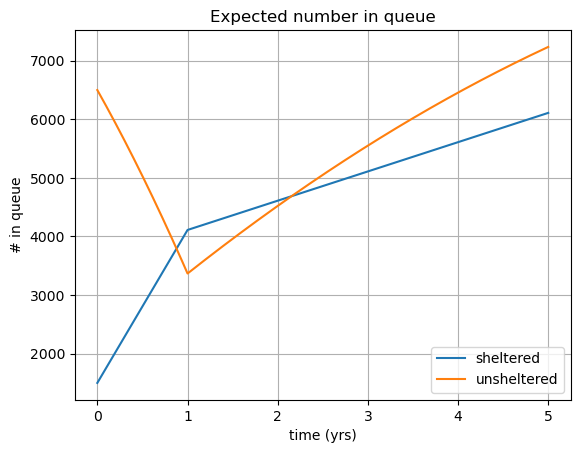

In [8]:
x = math.floor(horizon*365)/365

# plot queue dynamics - number unsheltered
fig, ax = plt.subplots()
ax.plot(np.arange(0,x,1/365), model_run.sh_t)
ax.plot(np.arange(0,x,1/365), model_run.unsh_t)

ax.set(xlabel='time (yrs)', ylabel='# in queue',
       title='Expected number in queue')

plt.legend(["sheltered", "unsheltered"], loc="lower right")

ax.grid()

plt.show()

####  Phi 3
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: increasing
    #      shape constraint on shelter building: increasing and then decreasing

In [9]:
#triangular shape
def h1(problem,n):
    return (problem.h[n+1] >= problem.h[n])

def s1(problem,n):
    return (problem.s[n+1] >= problem.s[n])

def s2(problem,n):
    return (problem.s[n+1] <= problem.s[n])

# Set up problem and solve
problem = do.Phi(data_as_is, 
                  timestep, 
                  horizon, 
                  budget, 
                  costs_accomm, 
                  baseline_build, 
                  budget_constraint, 
                  min_house_build, 
                  min_shelter_build,
                  y2)

problem.add_housing_increase(h1)
shelter_mode = 2
problem.add_shelter_increase_decrease(shelter_mode, s1, s2)
        
problem.solve('ipopt')

# Outputs
print('House building solution per year: ' + str([round(i,2) for i in problem.h_opt]))
print('Shelter building solution per year: ' + str([round(i,2) for i in problem.s_opt]))
print('Optimal objective Val: ' + str(round(problem.instance.OBJ(),2)))

House building solution per year: [795.71, 795.71, 795.71, 795.71, 795.71]
Shelter building solution per year: [2354.78, 2354.78, 2354.78, 500.0, 500.0]
Optimal objective Val: 61945456.97


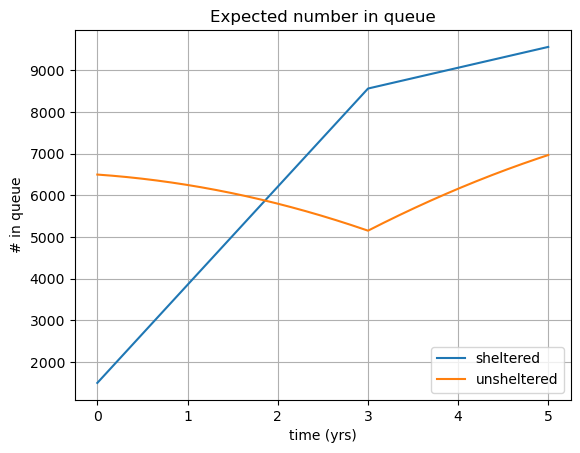

In [10]:
solution = {'housing':problem.h_opt, 'shelter':problem.s_opt}
model_run = fl.FluidFlowModel(data_as_is, solution)
T = [i*timestep for i in range(int(horizon/timestep))]
model_run.analyse(T)

x = math.floor(horizon*365)/365

# plot queue dynamics - number unsheltered
fig, ax = plt.subplots()
ax.plot(np.arange(0,x,1/365), model_run.sh_t)
ax.plot(np.arange(0,x,1/365), model_run.unsh_t)

ax.set(xlabel='time (yrs)', ylabel='# in queue',
       title='Expected number in queue')

plt.legend(["sheltered", "unsheltered"], loc="lower right")

ax.grid()

plt.show()

####  Phi 4
    # min TimeAvg(E[unsh(t)^2]) + WeightAvg(E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: increasing
    #      shape constraint on shelter building: increasing and then decreasing

In [11]:
# m should take value between 0 and 1 - this indicates the size of gradient of the weight function on the penalty on unsheltered queue. 
# 0 being no gradient, 1 being max possible gradient, given time horizon. 
m = 1.0

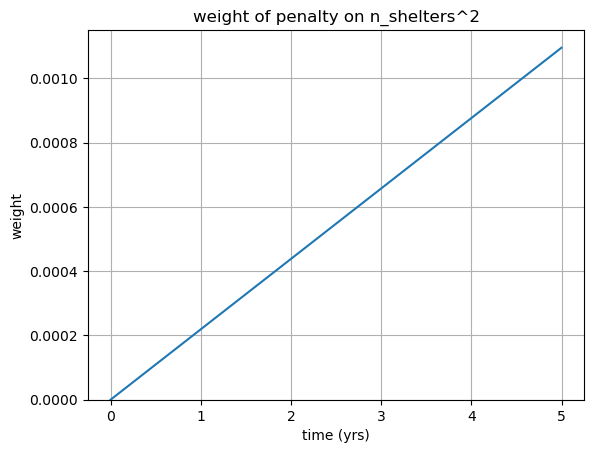

In [12]:
T = horizon/timestep
w1max = 2/(T**2)
w1 = m*w1max
w0 = (1/T) - ((w1*T)/2)
x = list(np.arange(0,horizon,timestep))
w = [i*w1 + w0 for i in range(int(horizon/timestep))]

fig, ax = plt.subplots()
ax.plot(x,w)
ax.set_ylim(bottom=0)

ax.set(xlabel='time (yrs)', ylabel='weight',
       title='weight of penalty on n_shelters^2')

ax.grid()
plt.show()

In [13]:
def y4(problem):
    " objective function for problem Phi4"
    solution = {'housing' : problem.h, 'shelter' : problem.s}
    fluid_model = model(data_as_is, solution)
    fluid_model.analyse(horizon, timestep)
    avg_unsh_2 = sum(fluid_model.model.unsh_sq_t)/len(fluid_model.model.unsh_sq_t)
    weight_avg_sh_2 = sum([fluid_model.model.sh_sq_t[i]*w[i] for i in range(int(horizon/timestep))])
    return(avg_unsh_2 + weight_avg_sh_2)

# Set up problem and solve
problem = do.Phi(data_as_is, 
                  timestep, 
                  horizon, 
                  budget, 
                  costs_accomm, 
                  baseline_build, 
                  budget_constraint, 
                  min_house_build, 
                  min_shelter_build,
                  y4)

problem.add_housing_increase(h1)
shelter_mode = 2
problem.add_shelter_increase_decrease(shelter_mode, s1, s2)
        
problem.solve('ipopt')

# Outputs
print('House building solution per year: ' + str([round(i,2) for i in problem.h_opt]))
print('Shelter building solution per year: ' + str([round(i,2) for i in problem.s_opt]))
print('Optimal objective Val: ' + str(round(problem.instance.OBJ(),2)))

House building solution per year: [1087.85, 1087.85, 1087.85, 1087.85, 1087.85]
Shelter building solution per year: [894.09, 894.09, 894.09, 500.0, 500.0]
Optimal objective Val: 83969071.16


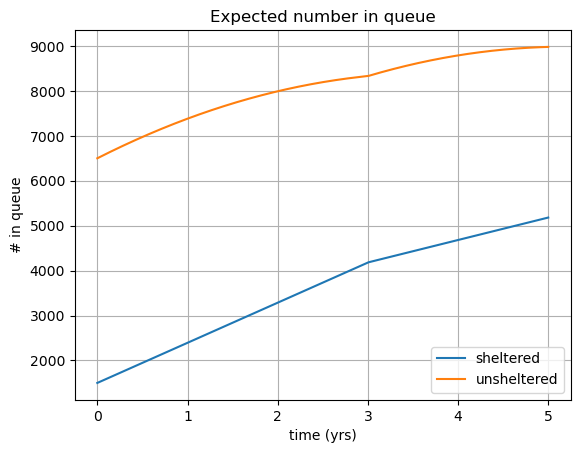

In [14]:
solution = {'housing':problem.h_opt, 'shelter':problem.s_opt}
model_run = fl.FluidFlowModel(data_as_is, solution)
T = [i*timestep for i in range(int(horizon/timestep))]
model_run.analyse(T)

x = math.floor(horizon*365)/365

# plot queue dynamics - number unsheltered
fig, ax = plt.subplots()
ax.plot(np.arange(0,x,1/365), model_run.sh_t)
ax.plot(np.arange(0,x,1/365), model_run.unsh_t)

ax.set(xlabel='time (yrs)', ylabel='# in queue',
       title='Expected number in queue')

plt.legend(["sheltered", "unsheltered"], loc="lower right")

ax.grid()

plt.show()